# Pretrained Model
### The reason that it is introduced
* [ILSCVRC](http://image-net.org/)에서 1000개의 클래스를 classification하는 문제를 solving한 모델이 있다.
* 이모델은 1000개를 분류할 수 있는 능력이 있지만 수백만장의 이미지 데이터를 다시 트레이닝하는 것은 매우 무리다.
* 그래서 연구소에서는 이모델을 open source로 제공하는 방향으로 연구를 하고 이를 우리는 사용해 좋은 **visual features **를 이용할 수 있게 되었다.
* 사용법은 매우 간단하다.

In [1]:
import os
import random

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

random_seed = 4332
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
transform_train = transforms.Compose(
    [transforms.RandomResizedCrop(224), # Data augmentation, 224 = image size, ImageNet pretrained model을 위해서 resize
     # 224여야만 제대로 동작할 정도로 사이즈에 민감하다.
     transforms.RandomRotation(5),
     transforms.RandomHorizontalFlip(), # Data 수 늘어나는 효과. data augmentation
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) # -1 ~ 1. dataset의 mean, std을 이요해서 normalize 

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## TO DO - Load and Define pretrained model and fine-tuning
- Use torchvision.models.resnet18
- Re-define the last fully connected layer for our task (ImageNet Dataset: 1000 classes, CIFAR10 Dataset: 10 classes, so set the last fully connected layer's out_features to 10) 

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:
# resnet_cls = models.resnet18(pretrained=True)
class ResNet18(nn.Module):
    def __init__ (self):
        super(ResNet18, self).__init__()
        # TODO
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10) #원래는 1000개였는데 10개로 수정
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        x = self.resnet(x) # Batch_size x 10
        return x
    
# resnet_cls = models.resnet50(pretrained=True)
class ResNet50(nn.Module):
    def __init__ (self):
        super(ResNet50, self).__init__()
        # TODO
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10) #원래는 1000개였는데 10개로 수정
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        x = self.resnet(x) # Batch_size x 10
        return x
    
    # resnet_cls = models.resnet101(pretrained=True)
class ResNet101(nn.Module):
    def __init__ (self):
        super(ResNet101, self).__init__()
        # TODO
        self.resnet = models.resnet101(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10) #원래는 1000개였는데 10개로 수정
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        x = self.resnet(x) # Batch_size x 10
        return x

## Load Model

In [5]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
net = ResNet101()

os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
# net = nn.DataParallel(net, output_device=1)

net = torch.nn.DataParallel(net)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/piai/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


## Training

In [6]:
training_epochs = 100
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9)
net.train()

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,250], gamma=0.1)

for epoch in range(training_epochs):        
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = net(inputs) 
        loss =  criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
    
    
    if epoch % 20 == 19:
        #test the model
        net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for index, [data, label] in enumerate(testloader):
                data = data.to(device)
                label = label.to(device)

                output = net.forward(data)
                _, prediction_index = torch.max(output, 1)

                total += label.size(0)
                correct += (prediction_index == label).sum().float()

            if total == 0:
                total = 1
            print('[%d] loss: %.10f        accuracy: %.4f' % (epoch + 1, loss.item() / 100, correct/total))

        net.train()
    else:
        print('[%d] loss: %.10f' % (epoch + 1, loss.item() / 100))
        
    scheduler.step()
        
print('Finished Training')

[1] loss: 0.0183962417
[2] loss: 0.0155374122
[3] loss: 0.0181840861
[4] loss: 0.0163782084
[5] loss: 0.0128357100
[6] loss: 0.0144871259
[7] loss: 0.0127426946
[8] loss: 0.0109352744
[9] loss: 0.0126859951
[10] loss: 0.0158406663
[11] loss: 0.0115061498
[12] loss: 0.0206506944
[13] loss: 0.0134550643
[14] loss: 0.0092564547
[15] loss: 0.0195684874
[16] loss: 0.0104811132
[17] loss: 0.0039616579
[18] loss: 0.0144706011
[19] loss: 0.0064257157
[20] loss: 0.0095307231        accuracy: 0.6982
[21] loss: 0.0060276526
[22] loss: 0.0066305095
[23] loss: 0.0125448811
[24] loss: 0.0119917083
[25] loss: 0.0119951117
[26] loss: 0.0111771524
[27] loss: 0.0055991763
[28] loss: 0.0059808493
[29] loss: 0.0064156866
[30] loss: 0.0069927084
[31] loss: 0.0129286790
[32] loss: 0.0134640455
[33] loss: 0.0083494836
[34] loss: 0.0114632821
[35] loss: 0.0071748006
[36] loss: 0.0044111225
[37] loss: 0.0081179464
[38] loss: 0.0068502939
[39] loss: 0.0072982252
[40] loss: 0.0135961092        accuracy: 0.7759
[

[319] loss: 0.0018510686
[320] loss: 0.0002068888        accuracy: 0.8707
[321] loss: 0.0000463228
[322] loss: 0.0021248704
[323] loss: 0.0020759070
[324] loss: 0.0003630990
[325] loss: 0.0058529520
[326] loss: 0.0017090385
[327] loss: 0.0021582802
[328] loss: 0.0030712479
[329] loss: 0.0024950595
[330] loss: 0.0009298094
[331] loss: 0.0013858758
[332] loss: 0.0002718094
[333] loss: 0.0017745072
[334] loss: 0.0041279036
[335] loss: 0.0028615779
[336] loss: 0.0010233604
[337] loss: 0.0017889258
[338] loss: 0.0028075269
[339] loss: 0.0022619005
[340] loss: 0.0010896260        accuracy: 0.8724
[341] loss: 0.0004049917
[342] loss: 0.0000943293
[343] loss: 0.0021493256
[344] loss: 0.0003168377
[345] loss: 0.0041306877
[346] loss: 0.0045656961
[347] loss: 0.0015389287
[348] loss: 0.0018317713
[349] loss: 0.0031377649
[350] loss: 0.0018098548
Finished Training


## Test

In [7]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('Mean Accuracy : ', 100*np.sum(class_correct)/np.sum(class_total))

Accuracy of plane : 89.200000 %
Accuracy of   car : 92.300000 %
Accuracy of  bird : 81.100000 %
Accuracy of   cat : 77.200000 %
Accuracy of  deer : 85.100000 %
Accuracy of   dog : 81.500000 %
Accuracy of  frog : 92.500000 %
Accuracy of horse : 89.400000 %
Accuracy of  ship : 90.600000 %
Accuracy of truck : 90.000000 %
Mean Accuracy :  86.89


## Visualization

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
# Get a batch of training data
dataiter = iter(testloader)

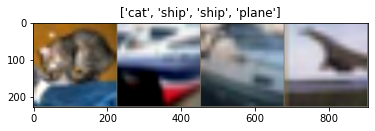

In [9]:
inputs, labels = dataiter.next()
outputs = net(inputs.cuda())
_, predicted = torch.max(outputs.data, 1)
imshow(torchvision.utils.make_grid(inputs), title=[classes[x] for x in predicted])